### Risk score calculation

The final assessment on the re-
silience of the air traffic network against potential sudden
disruptive events like natural catastrophes or epidemics at
different spatial scales will be based on the so-called **risk score**
calculation for each country or world region. The comparison
of countries will be based on the risk score (RS), which is
defined as follows:

$$
RS = \frac{(1 - ORPC_N) + (1 - A_N) + VR}{3} \cdot 100,
$$
where:
- \( ORPC_N \) represents the Outgoing Routes Per Capita normalized,
- \( A_N \) represents the Airports per country normalized,
- \( VR \) represents the Visa Restriction score.

The domains for each variable are given by:
- \( RS \in (0, 100] \),
- \( ORPC_N \in (0, 1] \),
- \( A_N \in (0, 1] \),
- \( VR \in (0, 1] \).

In [215]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#### Reading in the data

In [216]:
airports = pd.read_csv('EXPORTED_DATA/nodes.csv').rename(columns={'Unnamed: 0':'id'})
routes = pd.read_csv('EXPORTED_DATA/edges.csv')
geo_df = gpd.read_file('EXPORTED_DATA/UN_geodata.geojson')

#### Data preprocessing

All of the further calculations rely on a rather major simplification that we only look at routes where source country is not the destination country as well, meaning that we only consider routes that take passengers away from a certain country/region.

Adding source and destination country ISO codes to routes to filter out within-country flights.

In [217]:
#Adding source ISO code
routes = routes.merge(airports[['id', 'iso']], left_on='source', right_on='id', how='left')
routes.rename(columns={'iso': 'source_iso'}, inplace=True)
routes.drop('id', axis=1, inplace=True) 

#Adding destination ISO code
routes = routes.merge(airports[['id', 'iso']], left_on='destination', right_on='id', how='left')
routes.rename(columns={'iso': 'destination_iso'}, inplace=True)
routes.drop('id', axis=1, inplace=True)  # Clean up extra column

In [218]:
routes.shape

(36816, 12)

In [219]:
#Keeping only the international routes
routes_int = routes[routes['source_iso'] != routes['destination_iso']]
routes_int.shape

(19685, 12)

Now also only keep the airports that can be found among the source airports in the filtered routes dataset.

In [220]:
airports.shape

(3147, 9)

In [221]:
airports_int = airports[airports['id'].isin(routes_int['source'])]
airports_int.shape

(1213, 9)

### Outgoing Routes Per Capita normalized

Following metric is calculated using the 2014 population value. 

**NB!** Currently the airplane capacity is not taken into account!

In [263]:
geo_df['outgoing_routes'] = None
geo_df['or_per_capita_2014'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'outgoing_routes'] = len(routes[routes['source_iso'] == country])
    geo_df.loc[geo_df['Country Code'] == country, 'or_per_capita_2014'] = len(routes[routes['source_iso'] == country]) /  geo_df.loc[geo_df['Country Code'] == country, '2014']

In [264]:
from sklearn.preprocessing import QuantileTransformer

#Using a quantile transformer to avoid strongly skewed results (even after scaling)
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=100)

geo_df['orpc2014_n'] = scaler.fit_transform(geo_df[['or_per_capita_2014']]).flatten()
#geo_df['orpc2014_n'] = (geo_df['or_per_capita_2014'] - geo_df['or_per_capita_2014'].min()) / (geo_df['or_per_capita_2014'].max() - geo_df['or_per_capita_2014'].min())
geo_df['orpc2014_n'] = pd.to_numeric(geo_df['orpc2014_n'], errors='coerce')

Visualising the results.

In [265]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [266]:
geo_df.dtypes

Country Name              object
Country Code              object
2014                     float64
2022                     float64
Region                    object
IncomeGroup               object
OF Country Name           object
geometry                geometry
outgoing_routes           object
or_per_capita_2014        object
orpc2014_n               float64
area_sqkm                float64
airports                  object
airports_per_sqkm         object
apsqkm_n                 float64
avg_visa_restriction     float64
dtype: object

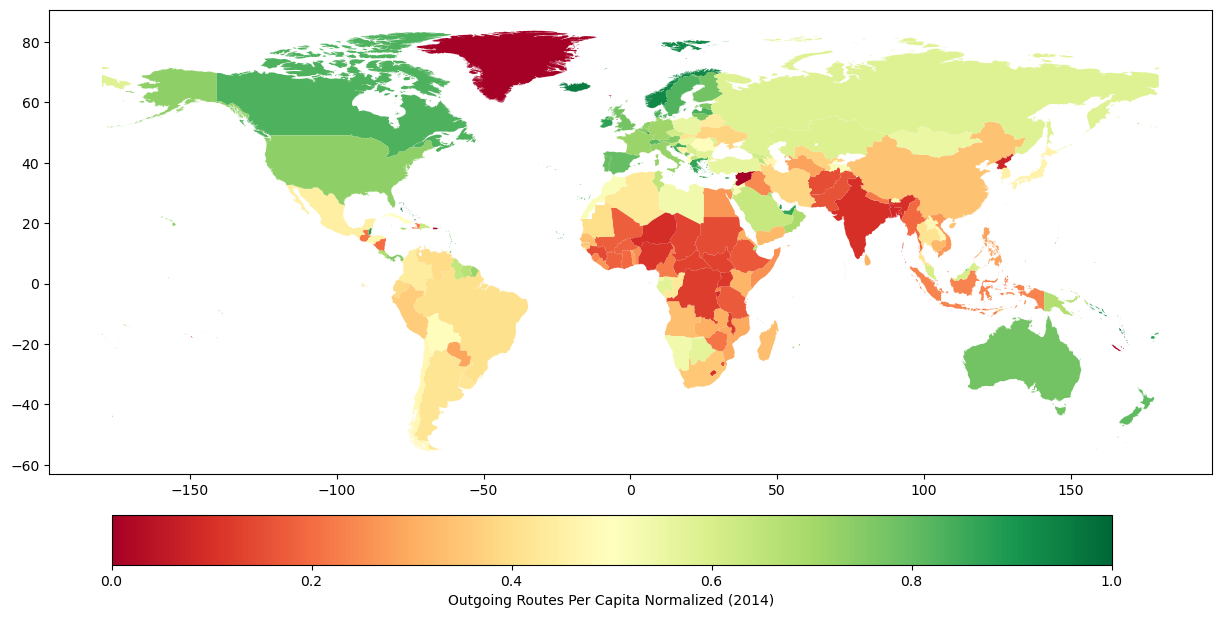

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cbar = geo_df.plot(column='orpc2014_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Outgoing Routes Per Capita Normalized (2014)",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [268]:
geo_df[geo_df['outgoing_routes'] == geo_df['outgoing_routes'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
193,United States,USA,318386329.0,333287557.0,North America,High income,United States,"MULTIPOLYGON (((179.67140 51.87718, 179.64210 ...",6498,0.00002,0.736355,9.464444e+06,525,0.000055,0.000862,0.008156


In [269]:
geo_df[geo_df['orpc2014_n'] == geo_df['orpc2014_n'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
147,Palau,PLW,17796.0,18055.0,East Asia & Pacific,Upper middle income,Palau,"MULTIPOLYGON (((131.81300 2.96044, 131.79518 2...",6,0.000337,1.0,491.93106,1,0.002033,0.031581,0.333333


### Airports per country normalized

In [226]:
invalid_geometries = geo_df[~geo_df.geometry.is_valid]

#Turns out that some of the polygons are invalid and need to be fixed in order to calculate the area properly
geo_df['geometry'] = geo_df.geometry.apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

In [227]:
print("Invalid geometries found after fixing:", geo_df[~geo_df.geometry.is_valid]) #None

Invalid geometries found after fixing: Empty GeoDataFrame
Columns: [Country Name, Country Code, 2014, 2022, Region, IncomeGroup, OF Country Name, geometry, outgoing_routes, or_per_capita_2014, orpc2014_n]
Index: []


In [270]:
#Find the areas of the countries

#Convert to an equal-area CRS
geo_df = geo_df.to_crs(epsg=6933) #Cylindrical Equal Area
#Area to square kilometers
geo_df['area_sqkm'] = geo_df.area / 1e6

geo_df = geo_df.to_crs(epsg=4326)

In [271]:
geo_df['airports'] = None
geo_df['airports_per_sqkm'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'airports'] = len(airports[airports['iso'] == country])
    geo_df.loc[geo_df['Country Code'] == country, 'airports_per_sqkm'] = len(airports[airports['iso'] == country]) /  geo_df.loc[geo_df['Country Code'] == country, 'area_sqkm']

In [272]:
from sklearn.preprocessing import QuantileTransformer

#Using a quantile transformer to avoid strongly skewed results (even after scaling)
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=100)

geo_df['apsqkm_n'] = scaler.fit_transform(geo_df[['airports_per_sqkm']]).flatten()
geo_df['apsqkm_n'] = pd.to_numeric(geo_df['apsqkm_n'], errors='coerce')

In [273]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

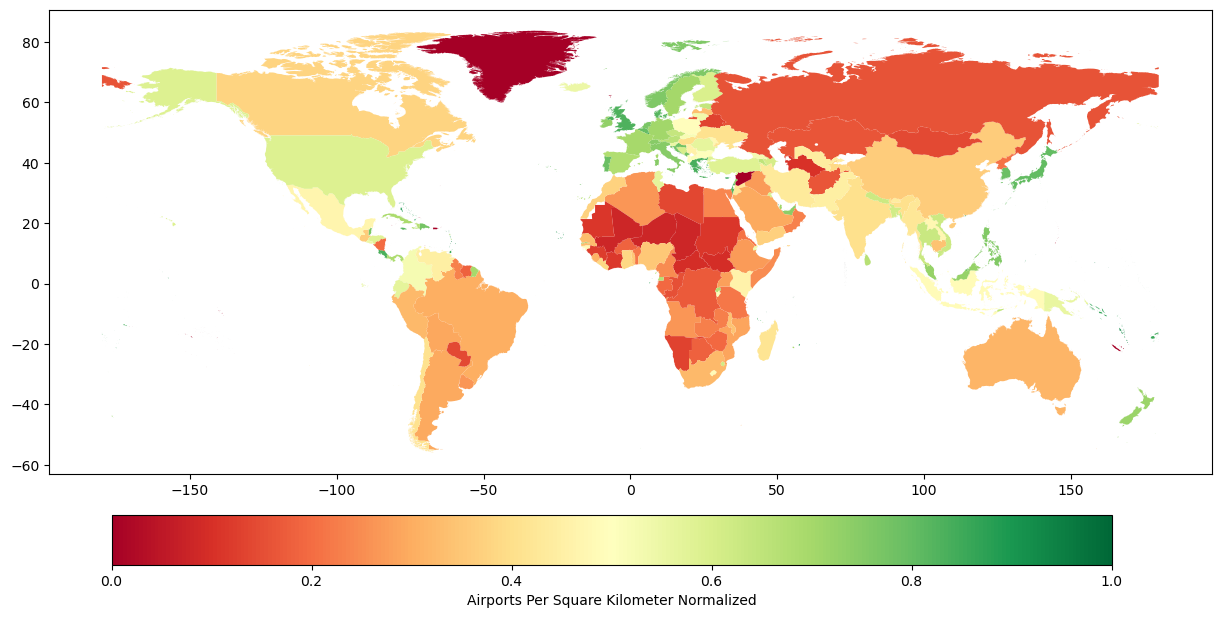

In [274]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='apsqkm_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Airports Per Square Kilometer Normalized",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [275]:
geo_df[geo_df['airports'] == geo_df['airports'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
193,United States,USA,318386329.0,333287557.0,North America,High income,United States,"MULTIPOLYGON (((179.67140 51.87718, 179.64210 ...",6498,0.00002,0.736355,9.464444e+06,525,0.000055,0.589089,0.008156


In [276]:
geo_df[geo_df['apsqkm_n'] == geo_df['apsqkm_n'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
117,Maldives,MDV,416738.0,523787.0,South Asia,Upper middle income,Maldives,"MULTIPOLYGON (((73.16310 -0.68182, 73.17254 -0...",41,0.000098,0.940752,108.749359,7,0.064368,1.0,0.073171


### Visa Restriction

In [239]:
routes

,source,destination,airline,equipment,avg_capacity,visa,source_lat,source_lon,dest_lat,dest_lon,source_iso,destination_iso
0,1,3,1308,DH8 DHT,10.0,0.0,-6.081690,145.391998,-5.826790,144.296005,PNG,PNG
1,1,4,1308,DH8,0.0,0.0,-6.081690,145.391998,-6.569803,146.725977,PNG,PNG
2,1,2,1308,DH8,0.0,0.0,-6.081690,145.391998,-5.207080,145.789001,PNG,PNG
3,1,5,328,DH4 DH8 DH3,43.0,0.0,-6.081690,145.391998,-9.443380,147.220001,PNG,PNG
4,2,1,1308,DH8,0.0,0.0,-5.207080,145.789001,-6.081690,145.391998,PNG,PNG
...,...,...,...,...,...,...,...,...,...,...,...,...
36811,8082,3393,15837,CR9,90.0,0.0,23.720600,106.959999,29.719200,106.641998,CHN,CHN
36812,8082,3372,15837,CR9,90.0,0.0,23.720600,106.959999,25.218100,110.039001,CHN,CHN
36813,8082,3370,2660,738,189.0,0.0,23.720600,106.959999,23.392401,113.299004,CHN,CHN
36814,8180,2537,13983,AT7,74.0,0.0,-21.513056,-43.173058,-19.624443,-43.971943,BRA,BRA


In [248]:
geo_df['avg_visa_restriction'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'avg_visa_restriction'] = np.sum(routes.loc[routes['source_iso'] == country, 'visa']) / len(routes[routes['source_iso'] == country])

geo_df['avg_visa_restriction'] = pd.to_numeric(geo_df['avg_visa_restriction'], errors='coerce')

/var/folders/5q/01tqbn6d2bn07z8n_c06sz400000gn/T/ipykernel_19342/1260321513.py:4: RuntimeWarning: invalid value encountered in scalar divide
  geo_df.loc[geo_df['Country Code'] == country, 'avg_visa_restriction'] = np.sum(routes.loc[routes['source_iso'] == country, 'visa']) / len(routes[routes['source_iso'] == country])


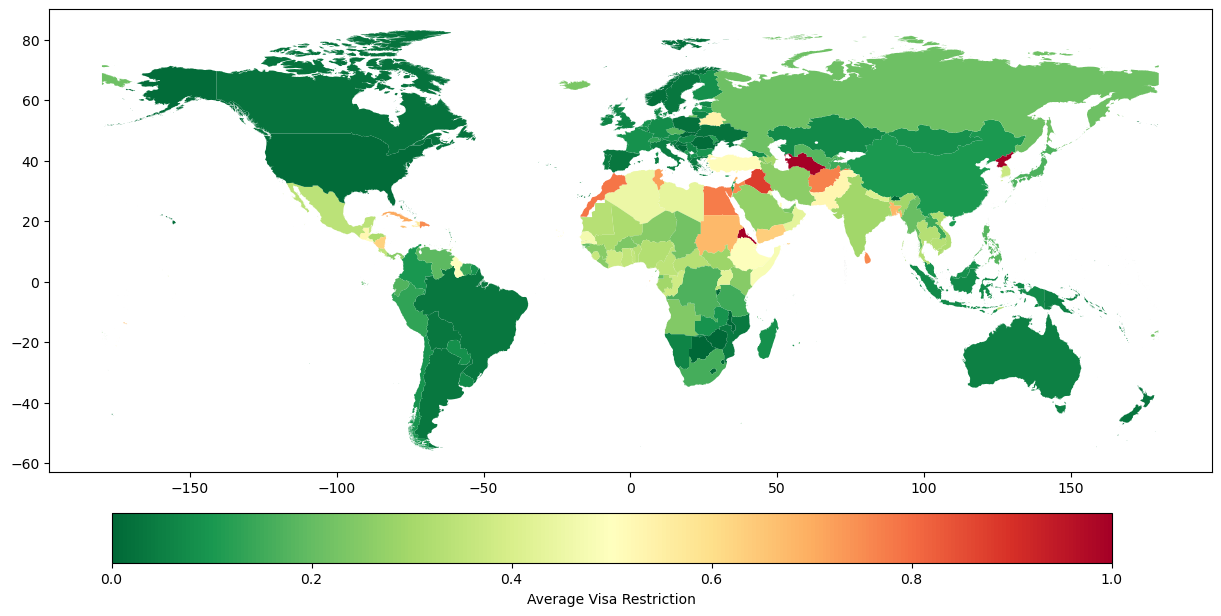

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='avg_visa_restriction', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Average Visa Restriction",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [252]:
geo_df[geo_df['avg_visa_restriction'] == geo_df['avg_visa_restriction'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
55,Eritrea,ERI,3323425.0,3684032.0,Sub-Saharan Africa,Low income,Eritrea,"MULTIPOLYGON (((40.02622 15.88264, 40.06267 15...",7,0.000002,0.006247,122537.888963,1,0.000008,0.000127,1.0
151,"Korea, Dem. People's Rep.",PRK,25126131.0,26069416.0,East Asia & Pacific,Low income,North Korea,"MULTIPOLYGON (((125.31275 37.74140, 125.29575 ...",4,0.0,0.000472,122379.346211,1,0.000008,0.000127,1.0
182,Turkmenistan,TKM,5663152.0,6430770.0,Europe & Central Asia,Upper middle income,Turkmenistan,"MULTIPOLYGON (((53.10206 38.75507, 53.09474 38...",11,0.000002,0.005761,470849.123915,1,0.000002,0.000033,1.0


In [253]:
geo_df[geo_df['avg_visa_restriction'] == geo_df['avg_visa_restriction'].min()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
12,Burundi,BDI,10494913.0,12889576.0,Sub-Saharan Africa,Low income,Burundi,"MULTIPOLYGON (((30.41507 -2.31309, 30.41848 -2...",3,0.0,0.000848,27041.228345,1,0.000037,0.000575,0.0
20,Bosnia and Herzegovina,BIH,3571068.0,3233526.0,Europe & Central Asia,Upper middle income,Bosnia and Herzegovina,"MULTIPOLYGON (((16.94153 45.24122, 16.94732 45...",17,0.000005,0.014120,51826.708347,3,0.000058,0.000899,0.0
28,Bhutan,BTN,736357.0,782455.0,South Asia,Lower middle income,Bhutan,"MULTIPOLYGON (((90.26180 28.33535, 90.26180 28...",5,0.000007,0.020140,40365.396408,1,0.000025,0.000385,0.0
29,Botswana,BWA,2260376.0,2630296.0,Sub-Saharan Africa,Upper middle income,Botswana,"MULTIPOLYGON (((25.25978 -17.79411, 25.21937 -...",19,0.000008,0.024931,579029.287274,4,0.000007,0.000107,0.0
49,Dominica,DMA,69371.0,72737.0,Latin America & Caribbean,Upper middle income,Dominica,"MULTIPOLYGON (((-61.36286 15.20181, -61.37409 ...",8,0.000115,0.342045,730.311955,1,0.001369,0.021273,0.0
63,"Micronesia, Fed. Sts.",FSM,109024.0,114164.0,East Asia & Pacific,Lower middle income,Micronesia,"MULTIPOLYGON (((154.81764 0.92219, 154.81284 0...",9,0.000083,0.244845,633.848575,4,0.006311,0.098040,0.0
109,Lesotho,LSO,2095242.0,2305825.0,Sub-Saharan Africa,Lower middle income,Lesotho,"MULTIPOLYGON (((28.98085 -28.90904, 28.99542 -...",1,0.0,0.001416,30106.435505,1,0.000033,0.000516,0.0
111,Luxembourg,LUX,556319.0,653103.0,Europe & Central Asia,High income,Luxembourg,"MULTIPOLYGON (((6.03863 50.14841, 6.06137 50.1...",54,0.000097,0.287900,2608.476217,1,0.000383,0.005956,0.0
119,Marshall Islands,MHL,50419.0,41569.0,East Asia & Pacific,Upper middle income,Marshall Islands,"MULTIPOLYGON (((168.71681 4.57477, 168.68539 4...",7,0.000139,0.411789,164.814334,2,0.012135,0.188523,0.0
130,Malawi,MWI,16477966.0,20405317.0,Sub-Saharan Africa,Low income,Malawi,"MULTIPOLYGON (((34.71161 -12.12081, 34.68897 -...",10,0.000001,0.001800,119397.803386,2,0.000017,0.000260,0.0


### Risk score

In [278]:
geo_df['risk_score'] = (((1 - geo_df['orpc2014_n']) + (1 - geo_df['apsqkm_n']) + geo_df['avg_visa_restriction']) / 3) * 100

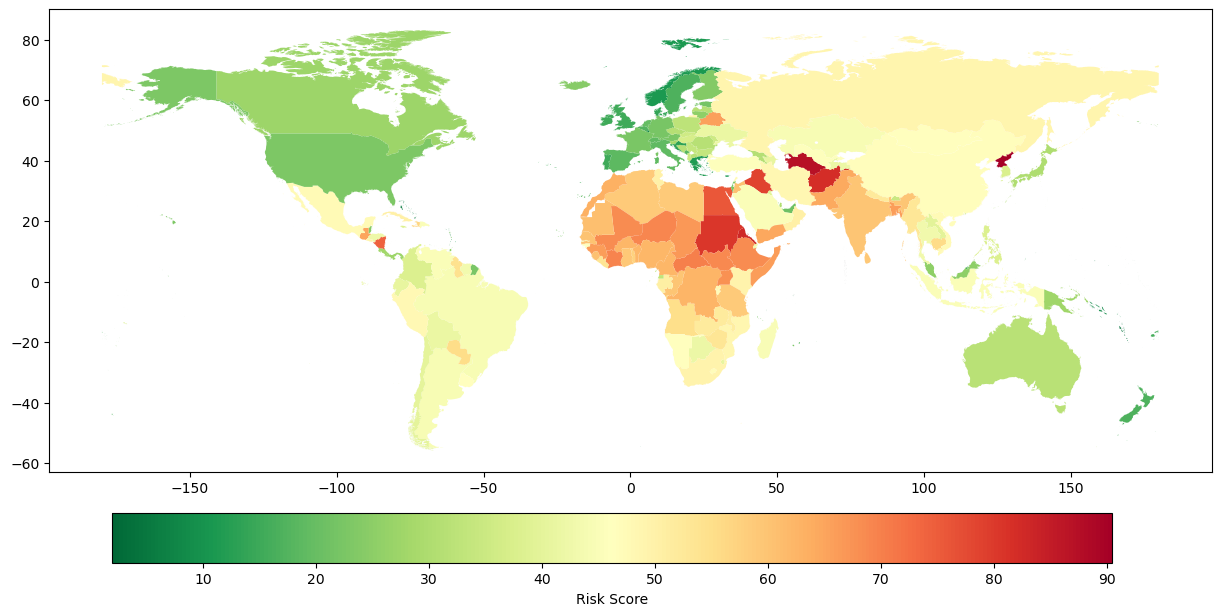

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='risk_score', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Risk Score",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()